In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Advanced Visualizations for Cluster Analysis
============================================
Tạo các biểu đồ chuyên nghiệp để phân tích cluster

Tác giả: AI Assistant
Ngày: 2024
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class ClusterVisualizer:
    """Class tạo các visualization chuyên nghiệp cho cluster analysis"""
    
    def __init__(self, output_dir: Path):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
    def plot_cluster_distribution(self, labels, save_path=None):
        """
        Biểu đồ phân bố số lượng học sinh trong mỗi cluster
        """
        unique, counts = np.unique(labels, return_counts=True)
        percentages = (counts / len(labels)) * 100
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Bar chart
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique)))
        bars = ax1.bar(unique, counts, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
        
        # Add value labels on bars
        for bar, count, pct in zip(bars, counts, percentages):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(count)}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax1.set_xlabel('Cluster ID', fontsize=13, fontweight='bold')
        ax1.set_ylabel('Number of Students', fontsize=13, fontweight='bold')
        ax1.set_title('Student Distribution Across Clusters', fontsize=15, fontweight='bold', pad=15)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_xticks(unique)
        
        # Pie chart
        explode = [0.05] * len(unique)
        wedges, texts, autotexts = ax2.pie(counts, labels=[f'Cluster {i}' for i in unique],
                                            autopct='%1.1f%%', startangle=90,
                                            colors=colors, explode=explode,
                                            shadow=True, textprops={'fontsize': 11, 'fontweight': 'bold'})
        ax2.set_title('Cluster Proportion', fontsize=15, fontweight='bold', pad=15)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"   ✓ Saved cluster distribution to {Path(save_path).name}")
        plt.close()
    
    def plot_feature_importance_heatmap(self, X, labels, feature_names, top_n=15, save_path=None):
        """
        Heatmap chuyên nghiệp so sánh features quan trọng nhất giữa các cluster
        """
        df = pd.DataFrame(X, columns=feature_names)
        df['cluster'] = labels
        
        # Calculate mean per cluster
        cluster_means = df.groupby('cluster')[feature_names].mean()
        
        # Find most distinctive features (highest variance across clusters)
        feature_variance = cluster_means.var(axis=0).sort_values(ascending=False)
        top_features = feature_variance.head(top_n).index.tolist()
        
        # Prepare data
        heatmap_data = cluster_means[top_features].T
        
        # Create figure with custom size
        fig, ax = plt.subplots(figsize=(12, max(8, len(top_features) * 0.4)))
        
        # Create heatmap with better color scheme
        sns.heatmap(heatmap_data,
                   annot=True,
                   fmt='.3f',
                   cmap='RdYlGn',
                   center=0,
                   vmin=-2, vmax=2,
                   linewidths=1,
                   linecolor='gray',
                   cbar_kws={'label': 'Feature Value (z-score)', 'shrink': 0.8},
                   annot_kws={'size': 9},
                   ax=ax)
        
        # Improve labels
        ax.set_xlabel('Cluster ID', fontsize=13, fontweight='bold', labelpad=10)
        ax.set_ylabel('Features', fontsize=13, fontweight='bold', labelpad=10)
        ax.set_title(f'Top {top_n} Most Distinctive Features Across Clusters',
                    fontsize=15, fontweight='bold', pad=20)
        
        # Format y-axis labels (shorten long names)
        y_labels = [label.get_text()[:50] + '...' if len(label.get_text()) > 50 
                   else label.get_text() for label in ax.get_yticklabels()]
        ax.set_yticklabels(y_labels, rotation=0, fontsize=10)
        
        # Format x-axis
        ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_means))], 
                          rotation=0, fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"   ✓ Saved feature heatmap to {Path(save_path).name}")
        plt.close()
    
    def plot_cluster_profiles_radar(self, X, labels, feature_names, key_features=None, save_path=None):
        """
        Radar chart (spider chart) chuyên nghiệp cho cluster profiles
        """
        df = pd.DataFrame(X, columns=feature_names)
        df['cluster'] = labels
        
        # Select key features
        if key_features is None:
            # Auto-select top varying features
            cluster_means = df.groupby('cluster')[feature_names].mean()
            feature_variance = cluster_means.var(axis=0).sort_values(ascending=False)
            key_features = feature_variance.head(8).index.tolist()
        
        cluster_means = df.groupby('cluster')[key_features].mean()
        n_clusters = len(cluster_means)
        n_features = len(key_features)
        
        # Normalize to [0, 1] for better visualization
        cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min() + 1e-10)
        
        # Create radar chart
        angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False).tolist()
        angles += angles[:1]
        
        fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
        
        colors = plt.cm.Set2(np.linspace(0, 1, n_clusters))
        
        for idx, (cluster_id, values) in enumerate(cluster_means_norm.iterrows()):
            values_plot = values.tolist()
            values_plot += values_plot[:1]
            
            ax.plot(angles, values_plot, 'o-', linewidth=2.5, markersize=8,
                   label=f'Cluster {cluster_id}', color=colors[idx])
            ax.fill(angles, values_plot, alpha=0.2, color=colors[idx])
        
        # Customize
        ax.set_xticks(angles[:-1])
        feature_labels = [f[:30] + '...' if len(f) > 30 else f for f in key_features]
        ax.set_xticklabels(feature_labels, fontsize=11, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='gray')
        ax.set_title('Cluster Profiles - Comparative Analysis',
                    fontsize=16, fontweight='bold', pad=30)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.15), fontsize=12, frameon=True, shadow=True)
        ax.grid(True, linewidth=0.5, alpha=0.5)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"   ✓ Saved radar chart to {Path(save_path).name}")
        plt.close()
    
    def plot_key_metrics_comparison(self, X, labels, feature_names, save_path=None):
        """
        Bar charts so sánh các metrics quan trọng giữa clusters
        """
        df = pd.DataFrame(X, columns=feature_names)
        df['cluster'] = labels
        
        # Select key metrics (auto-detect common important features)
        key_terms = ['grade', 'score', 'event', 'submit', 'view', 'attempt', 'complete']
        key_metrics = [f for f in feature_names if any(term in f.lower() for term in key_terms)]
        
        # If not enough, take top varying features
        if len(key_metrics) < 4:
            cluster_means = df.groupby('cluster')[feature_names].mean()
            feature_variance = cluster_means.var(axis=0).sort_values(ascending=False)
            key_metrics = feature_variance.head(6).index.tolist()
        else:
            key_metrics = key_metrics[:6]
        
        n_metrics = len(key_metrics)
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        cluster_means = df.groupby('cluster')[key_metrics].mean()
        n_clusters = len(cluster_means)
        colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
        
        for idx, metric in enumerate(key_metrics):
            ax = axes[idx]
            values = cluster_means[metric]
            
            bars = ax.bar(range(n_clusters), values, color=colors,
                         edgecolor='black', linewidth=1.5, alpha=0.8)
            
            # Add value labels
            for i, (bar, val) in enumerate(zip(bars, values)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.3f}',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            # Customize
            metric_label = metric.replace('\\', '\n').replace('_', ' ')
            if len(metric_label) > 40:
                metric_label = metric_label[:40] + '...'
            
            ax.set_title(metric_label, fontsize=11, fontweight='bold', pad=10)
            ax.set_xlabel('Cluster ID', fontsize=10, fontweight='bold')
            ax.set_ylabel('Mean Value', fontsize=10, fontweight='bold')
            ax.set_xticks(range(n_clusters))
            ax.set_xticklabels([f'C{i}' for i in range(n_clusters)], fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_ylim(bottom=min(0, values.min() * 1.1), top=values.max() * 1.2)
        
        # Hide extra subplots
        for idx in range(n_metrics, len(axes)):
            axes[idx].axis('off')
        
        fig.suptitle('Key Metrics Comparison Across Clusters', 
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"   ✓ Saved key metrics comparison to {Path(save_path).name}")
        plt.close()
    
    def plot_cluster_scatter_2d(self, X_2d, labels, method='PCA', save_path=None):
        """
        Scatter plot 2D chuyên nghiệp với annotations
        """
        fig, ax = plt.subplots(figsize=(12, 10))
        
        n_clusters = len(np.unique(labels))
        colors = plt.cm.Set2(np.linspace(0, 1, n_clusters))
        
        # Plot each cluster
        for cluster_id in range(n_clusters):
            mask = labels == cluster_id
            cluster_points = X_2d[mask]
            
            scatter = ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                               c=[colors[cluster_id]], s=80, alpha=0.6,
                               edgecolors='black', linewidth=0.5,
                               label=f'Cluster {cluster_id} (n={mask.sum()})')
            
            # Add cluster centroid
            centroid = cluster_points.mean(axis=0)
            ax.scatter(centroid[0], centroid[1], c=[colors[cluster_id]],
                      s=500, marker='*', edgecolors='black', linewidth=2,
                      alpha=1.0, zorder=10)
            
            # Add cluster label
            ax.text(centroid[0], centroid[1], f'{cluster_id}',
                   ha='center', va='center', fontsize=14, fontweight='bold',
                   color='white', zorder=11)
        
        # Customize
        ax.set_xlabel(f'{method} Component 1', fontsize=13, fontweight='bold')
        ax.set_ylabel(f'{method} Component 2', fontsize=13, fontweight='bold')
        ax.set_title(f'Cluster Visualization - {method} 2D Projection',
                    fontsize=16, fontweight='bold', pad=20)
        ax.legend(loc='best', fontsize=11, frameon=True, shadow=True, ncol=min(2, (n_clusters+1)//2))
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"   ✓ Saved 2D scatter plot to {Path(save_path).name}")
        plt.close()
    
    def plot_silhouette_analysis(self, X, labels, save_path=None):
        """
        Silhouette analysis plot cho đánh giá chất lượng cluster
        """
        from sklearn.metrics import silhouette_samples
        
        n_clusters = len(np.unique(labels))
        silhouette_vals = silhouette_samples(X, labels)
        silhouette_avg = silhouette_vals.mean()
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        y_lower = 10
        colors = plt.cm.Set2(np.linspace(0, 1, n_clusters))
        
        for i in range(n_clusters):
            cluster_silhouette_vals = silhouette_vals[labels == i]
            cluster_silhouette_vals.sort()
            
            size_cluster_i = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, cluster_silhouette_vals,
                            facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
            
            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{i}',
                   fontsize=12, fontweight='bold')
            
            y_lower = y_upper + 10
        
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
                  label=f'Average Silhouette Score: {silhouette_avg:.3f}')
        
        ax.set_xlabel('Silhouette Coefficient', fontsize=13, fontweight='bold')
        ax.set_ylabel('Cluster', fontsize=13, fontweight='bold')
        ax.set_title('Silhouette Analysis for Cluster Quality',
                    fontsize=16, fontweight='bold', pad=20)
        ax.legend(loc='best', fontsize=11, frameon=True, shadow=True)
        ax.set_yticks([])
        ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"   ✓ Saved silhouette analysis to {Path(save_path).name}")
        plt.close()
    
    def create_comprehensive_report(self, X, X_2d, labels, feature_names, 
                               method='PCA', cluster_stats=None, show_immediately=False):
        """
        Tạo một báo cáo visualization toàn diện.
        
        Parameters:
        -----------
        X : np.ndarray
            Dữ liệu features gốc.
        X_2d : np.ndarray
            Dữ liệu 2D (PCA/UMAP) để scatter plot.
        labels : np.ndarray
            Cluster labels.
        feature_names : list
            Tên các features.
        method : str
            Tên phương pháp giảm chiều ('PCA' hoặc 'UMAP').
        cluster_stats : dict
            Thống kê cluster (từ analyze_cluster_profiles).
        show_immediately : bool
            Nếu True, hiển thị từng biểu đồ ngay sau khi tạo.
        """
        print("\n" + "="*70)
        print("📊 CREATING COMPREHENSIVE VISUALIZATION REPORT")
        print("="*70)

        # Danh sách các hàm plot và tên file tương ứng
        plots = [
            (self.plot_cluster_distribution, (labels,), "01_cluster_distribution.png"),
            (self.plot_cluster_scatter_2d, (X_2d, labels, method), f"02_cluster_scatter_{method.lower()}.png"),
            (self.plot_feature_importance_heatmap, (X, labels, feature_names, 15), "03_feature_importance_heatmap.png"),
            (self.plot_cluster_profiles_radar, (X, labels, feature_names, None), "04_cluster_profiles_radar.png"),
            (self.plot_key_metrics_comparison, (X, labels, feature_names), "05_key_metrics_comparison.png"),
            (self.plot_silhouette_analysis, (X, labels), "06_silhouette_analysis.png")
        ]

        # Chạy từng plot một
        for plot_func, args, filename in plots:
            save_path = self.output_dir / filename
            
            # GỌI HÀM VẼ (đã được sửa trong class để trả về fig nếu cần)
            # Lưu ý: Vì bạn chưa sửa các hàm trong Class, 
            # chúng ta vẫn gọi theo cách cũ, nhưng cần bỏ qua việc gọi fig.show() 
            # vì các hàm này không trả về fig.
            
            plot_func(*args, save_path=save_path)
            
            if show_immediately:
                # Nếu muốn hiển thị từng cái, cần sửa hàm gốc 
                # để bỏ plt.close() và thêm plt.show()
                # Ở đây ta giả định việc hiển thị được quản lý bởi hàm phụ trợ `show_all_together`
                pass


        print("\n✅ Comprehensive visualization report complete!")
        print(f"📁 All visualizations saved to: {self.output_dir}/")
        
        # Gọi hàm hiển thị tất cả các ảnh đã lưu
        if not show_immediately:
            print("\n✨ Calling show_all_together() to display the saved report (6 charts)...")
            self.show_all_together()
    
    def show_all_together(self):
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        from pathlib import Path

        # Cần tìm tên file 02_cluster_scatter_* chính xác đã được lưu
        
        # Tìm file 02_cluster_scatter_*.png trong thư mục đầu ra
        scatter_files = list(self.output_dir.glob("02_cluster_scatter_*.png"))
        scatter_file = scatter_files[0].name if scatter_files else "02_cluster_scatter_pca.png" 

        files = [
            "01_cluster_distribution.png",
            scatter_file, # Sử dụng tên file đã tìm được
            "03_feature_importance_heatmap.png",
            "04_cluster_profiles_radar.png",
            "05_key_metrics_comparison.png",
            "06_silhouette_analysis.png"
        ]

        fig, axes = plt.subplots(2, 3, figsize=(15, 9))
        fig.suptitle('Comprehensive Cluster Analysis Report', fontsize=16, fontweight='bold')
        axes = axes.flatten()
        
        for ax, file in zip(axes, files):
            try:
                img = mpimg.imread(Path(self.output_dir) / file)
                ax.imshow(img)
                title = file.replace('.png', '').replace('_', ' ').title()
                ax.set_title(title, fontsize=10)
                ax.axis('off')
            except FileNotFoundError:
                ax.set_title(f"File Not Found: {file}", color='red')
                ax.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh để không chồng lên suptitle
        plt.show() # Lệnh này sẽ hiển thị tất cả 6 ảnh cùng lúc



FEATURE PREPROCESSING FOR KMEANS CLUSTERING
Loading data from ../data/features_scaled_report.json...
Loaded 15 students with 69 features

1. Removing low-variance features (threshold=0.01)...
   Removed 0 features with variance < 0.01
   Remaining: 69 features

2. Removing highly correlated features (threshold=0.9)...
   Removed 44 highly correlated features
   Remaining: 25 features
   Removed features: \assignsubmission_file\event\submission_updated, \assignsubmission_onlinetext\event\assessable_uploaded, \assignsubmission_onlinetext\event\submission_created, \assignsubmission_onlinetext\event\submission_updated, \core\event\course_viewed... and 39 more
   Saved correlation heatmap to ../data/processed/correlation_heatmap_cleaned.png

3. Applying PCA (target variance=0.95)...
   Original dimensions: 25
   PCA components for 95% variance: 10
   Total explained variance with 10 components: 95.99%
   Saved correlation heatmap to ../data/processed/correlation_heatmap_cleaned.png

3. Appl

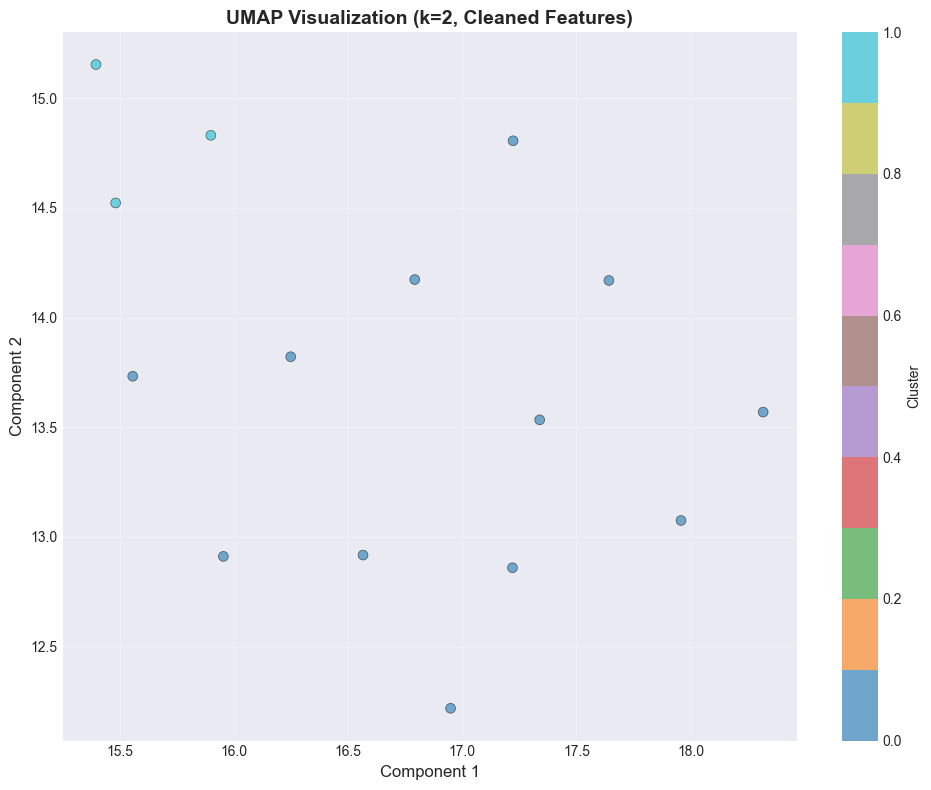

   Saved cluster visualization to ../data/processed/cluster_viz_pca2d_cleaned.png


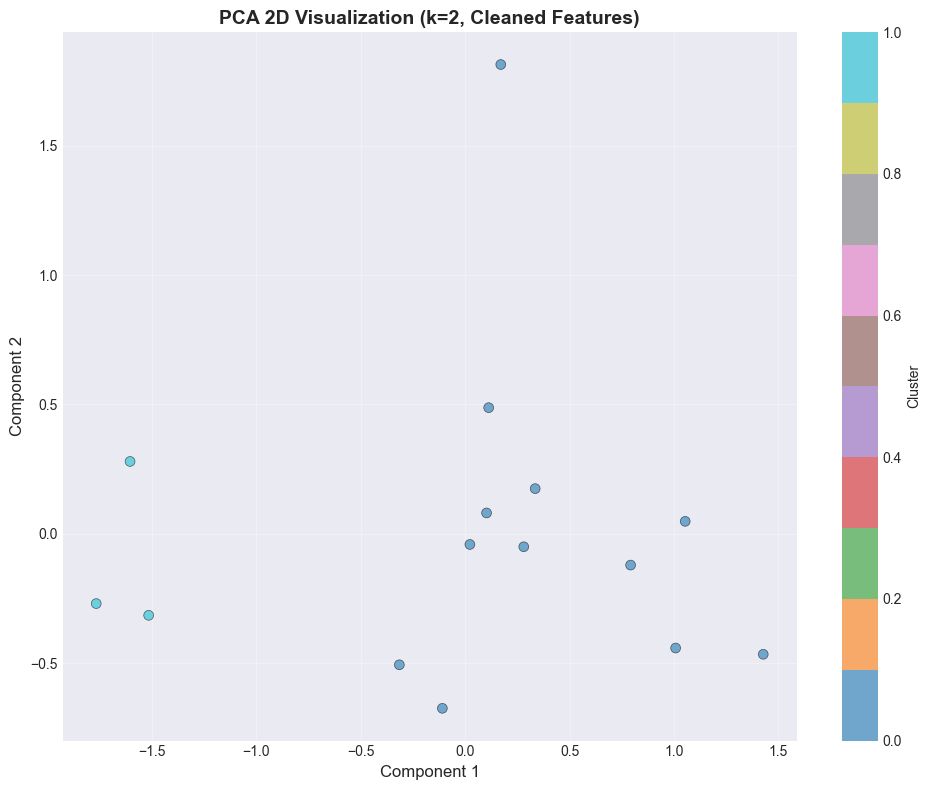


📊 Analyzing Cluster Profiles...

CLUSTER 0 - 12 students (80.0%)

✅ Top 5 Strengths (above average):
   \mod_quiz\event\attempt_started         :    1.000 (z=+0.48)
   \mod_quiz\event\attempt_reviewed        :    0.667 (z=+0.36)
   \mod_data\event\record_created          :    0.833 (z=+0.34)
   total_events                            :    0.676 (z=+0.34)
   \assignsubmission_file\event\submission_created:    0.891 (z=+0.33)

⚠️  Top 5 Weaknesses (below average):
   \gradereport_user\event\grade_report_viewed:    0.297 (z=+0.13)
   \mod_assign\event\feedback_viewed       :    0.309 (z=+0.12)
   \core\event\recent_activity_viewed      :    0.167 (z=+0.11)
   \core\event\course_user_report_viewed   :    0.167 (z=+0.11)
   \gradereport_overview\event\grade_report_viewed:    0.125 (z=+0.09)

CLUSTER 1 - 3 students (20.0%)

✅ Top 5 Strengths (above average):
   \core\event\user_profile_viewed         :    0.333 (z=+1.03)
   \core\event\user_list_viewed            :    0.333 (z=+0.57)
   \mo

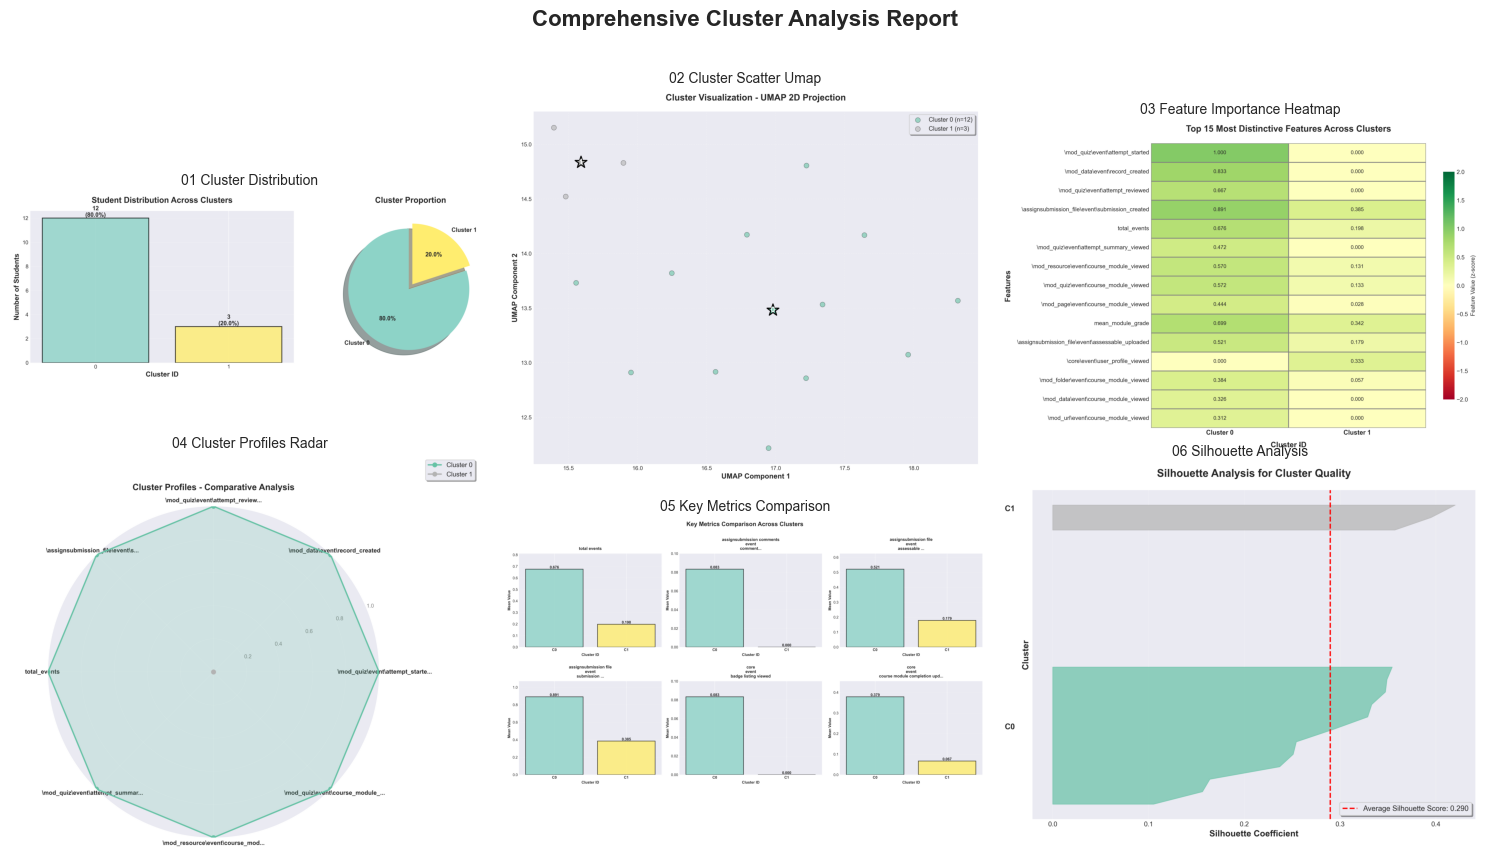


✨ Hiển thị báo cáo tổng hợp (6 biểu đồ trên một cửa sổ)...


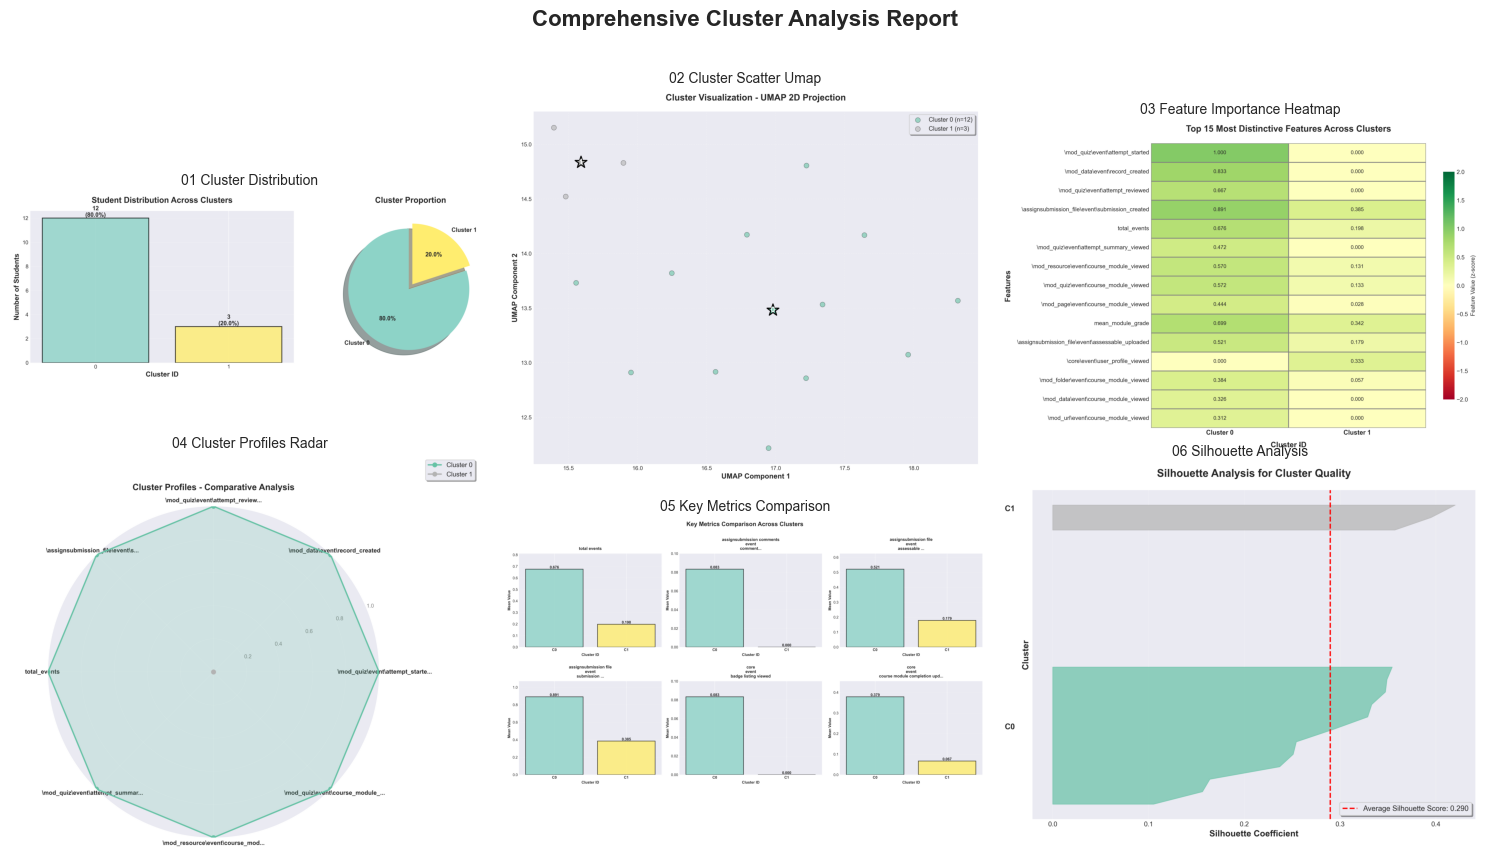


  All outputs saved to: ../data/processed/


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Feature Preprocessing cho KMeans Clustering
============================================
Xử lý features trước khi chạy KMeans:
- Loại bỏ features có phương sai thấp
- Loại bỏ features có tương quan cao
- Áp dụng PCA để giảm chiều
- Áp dụng UMAP để visualization

Tác giả: AI Assistant
Ngày: 2024
"""

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
# Import advanced visualization module

warnings.filterwarnings('ignore')

# Optional: UMAP (install: pip install umap-learn)
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("Warning: umap-learn not installed. UMAP visualization will be skipped.")
    print("Install with: pip install umap-learn")


class FeaturePreprocessor:
    """Xử lý features trước khi clustering"""
    
    def __init__(self, data_path: str, output_dir: str = None):
        """
        Parameters:
        -----------
        data_path : str
            Đường dẫn tới file JSON chứa features đã chuẩn hóa
        output_dir : str, optional
            Thư mục lưu kết quả (mặc định: cùng thư mục với data_path)
        """
        self.data_path = Path(data_path)
        self.output_dir = Path(output_dir) if output_dir else self.data_path.parent / "processed"
        self.output_dir.mkdir(exist_ok=True)
        
        # Load data
        print(f"Loading data from {self.data_path}...")
        with open(self.data_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        self.df = pd.DataFrame(data)
        
        # Separate userid and numeric features
        self.user_ids = self.df['userid'].values
        self.feature_cols = [col for col in self.df.columns if col != 'userid']
        self.X = self.df[self.feature_cols].fillna(0).values
        
        print(f"Loaded {len(self.df)} students with {len(self.feature_cols)} features")
        
        # Storage for results
        self.removed_features = {
            'low_variance': [],
            'high_correlation': []
        }
        self.X_cleaned = None
        self.cleaned_feature_names = None
        self.pca_model = None
        self.X_pca = None
        self.umap_model = None
        self.X_umap = None
        
    def remove_low_variance_features(self, threshold=0.01):
        """
        Loại bỏ features có phương sai thấp
        
        Parameters:
        -----------
        threshold : float
            Ngưỡng phương sai tối thiểu (mặc định: 0.01)
        """
        print(f"\n1. Removing low-variance features (threshold={threshold})...")
        
        selector = VarianceThreshold(threshold=threshold)
        X_selected = selector.fit_transform(self.X)
        
        # Get removed feature names
        mask = selector.get_support()
        removed = [feat for feat, keep in zip(self.feature_cols, mask) if not keep]
        self.removed_features['low_variance'] = removed
        
        # Update feature names
        self.cleaned_feature_names = [feat for feat, keep in zip(self.feature_cols, mask) if keep]
        self.X_cleaned = X_selected
        
        print(f"   Removed {len(removed)} features with variance < {threshold}")
        print(f"   Remaining: {X_selected.shape[1]} features")
        if removed:
            print(f"   Removed features: {', '.join(removed[:5])}" + 
                  (f"... and {len(removed)-5} more" if len(removed) > 5 else ""))
        
        return X_selected, self.cleaned_feature_names
    
    def remove_highly_correlated_features(self, corr_threshold=0.90):
        """
        Loại bỏ features có tương quan cao
        
        Parameters:
        -----------
        corr_threshold : float
            Ngưỡng tương quan (mặc định: 0.90)
        """
        print(f"\n2. Removing highly correlated features (threshold={corr_threshold})...")
        
        if self.X_cleaned is None:
            raise ValueError("Run remove_low_variance_features() first!")
        
        # Compute correlation matrix
        df_temp = pd.DataFrame(self.X_cleaned, columns=self.cleaned_feature_names)
        corr_matrix = df_temp.corr().abs()
        
        # Select upper triangle of correlation matrix
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        # Find features with correlation greater than threshold
        to_drop = [column for column in upper_tri.columns 
                   if any(upper_tri[column] > corr_threshold)]
        
        self.removed_features['high_correlation'] = to_drop
        
        # Drop correlated features
        df_temp = df_temp.drop(columns=to_drop)
        self.X_cleaned = df_temp.values
        self.cleaned_feature_names = df_temp.columns.tolist()
        
        print(f"   Removed {len(to_drop)} highly correlated features")
        print(f"   Remaining: {self.X_cleaned.shape[1]} features")
        if to_drop:
            print(f"   Removed features: {', '.join(to_drop[:5])}" + 
                  (f"... and {len(to_drop)-5} more" if len(to_drop) > 5 else ""))
        
        # Save correlation heatmap
        self._plot_correlation_matrix(df_temp.corr(), 
                                      save_path=self.output_dir / "correlation_heatmap_cleaned.png")
        
        return self.X_cleaned, self.cleaned_feature_names
    
    def apply_pca(self, explained_variance_ratio=0.95, max_components=None):
        """
        Áp dụng PCA để giảm chiều
        
        Parameters:
        -----------
        explained_variance_ratio : float
            Tỷ lệ phương sai cần giữ lại (mặc định: 0.95 = 95%)
        max_components : int, optional
            Số components tối đa (nếu None, tự động chọn theo explained_variance_ratio)
        """
        print(f"\n3. Applying PCA (target variance={explained_variance_ratio})...")
        
        if self.X_cleaned is None:
            raise ValueError("Run feature removal steps first!")
        
        # Fit PCA
        if max_components:
            n_components = min(max_components, self.X_cleaned.shape[1])
        else:
            n_components = min(self.X_cleaned.shape[1], self.X_cleaned.shape[0])
        
        pca = PCA(n_components=n_components)
        self.X_pca = pca.fit_transform(self.X_cleaned)
        self.pca_model = pca
        
        # Find optimal n_components for target variance
        cumsum_var = np.cumsum(pca.explained_variance_ratio_)
        optimal_n = np.argmax(cumsum_var >= explained_variance_ratio) + 1
        
        print(f"   Original dimensions: {self.X_cleaned.shape[1]}")
        print(f"   PCA components for {explained_variance_ratio*100:.0f}% variance: {optimal_n}")
        print(f"   Total explained variance with {optimal_n} components: "
              f"{cumsum_var[optimal_n-1]*100:.2f}%")
        
        # Truncate to optimal components
        self.X_pca = self.X_pca[:, :optimal_n]
        
        # Plot explained variance
        self._plot_pca_variance(pca, optimal_n, 
                               save_path=self.output_dir / "pca_explained_variance.png")
        
        return self.X_pca, optimal_n
    
    def apply_umap(self, n_components=2, n_neighbors=15, min_dist=0.1):
        """
        Áp dụng UMAP để visualization
        
        Parameters:
        -----------
        n_components : int
            Số chiều đầu ra (mặc định: 2 để plot)
        n_neighbors : int
            Số lân cận (mặc định: 15)
        min_dist : float
            Khoảng cách tối thiểu giữa các điểm (mặc định: 0.1)
        """
        if not UMAP_AVAILABLE:
            print("\n4. UMAP skipped (library not installed)")
            return None
        
        print(f"\n4. Applying UMAP (n_components={n_components})...")
        
        if self.X_cleaned is None:
            raise ValueError("Run feature removal steps first!")
        
        # Fit UMAP
        umap_model = umap.UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            random_state=42
        )
        self.X_umap = umap_model.fit_transform(self.X_cleaned)
        self.umap_model = umap_model
        
        print(f"   UMAP embedding shape: {self.X_umap.shape}")
        
        return self.X_umap
    
    def run_kmeans_analysis(self, X, k_range=(2, 11), data_label="Cleaned"):
        """
        Chạy KMeans với nhiều giá trị k và đánh giá
        
        Parameters:
        -----------
        X : np.ndarray
            Dữ liệu để cluster
        k_range : tuple
            Range của k để thử (min, max)
        data_label : str
            Nhãn cho dữ liệu (để lưu plot)
        """
        print(f"\n5. Running KMeans analysis on {data_label} features...")
        
        results = []
        for k in range(k_range[0], k_range[1]):
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = km.fit_predict(X)
            
            sil = silhouette_score(X, labels)
            dbi = davies_bouldin_score(X, labels)
            inertia = km.inertia_
            
            results.append({
                'k': k,
                'silhouette': sil,
                'davies_bouldin': dbi,
                'inertia': inertia,
                'labels': labels
            })
            
            print(f"   k={k}: silhouette={sil:.4f}, davies_bouldin={dbi:.4f}")
        
        # Plot elbow & silhouette
        self._plot_kmeans_metrics(results, 
                                  save_path=self.output_dir / f"kmeans_metrics_{data_label.lower()}.png")
        
        # Find best k (highest silhouette)
        best_result = max(results, key=lambda x: x['silhouette'])
        print(f"\n   Best k={best_result['k']} (silhouette={best_result['silhouette']:.4f})")
        
        return results, best_result
    
    def visualize_clusters(self, X_2d, labels, title="Cluster Visualization", 
                          save_path=None):
        """
        Visualize clusters trong không gian 2D
        
        Parameters:
        -----------
        X_2d : np.ndarray
            Dữ liệu 2D (từ PCA hoặc UMAP)
        labels : np.ndarray
            Cluster labels
        title : str
            Tiêu đề plot
        save_path : Path, optional
            Đường dẫn lưu plot
        """
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], 
                            c=labels, cmap='tab10', 
                            s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
        plt.colorbar(scatter, label='Cluster')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Component 1', fontsize=12)
        plt.ylabel('Component 2', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"   Saved cluster visualization to {save_path}")
        plt.show()
        plt.close()
    
    def save_results(self, best_k, labels):
        """
        Lưu tất cả kết quả
        
        Parameters:
        -----------
        best_k : int
            Số cluster tối ưu
        labels : np.ndarray
            Cluster labels
        """
        print(f"\n6. Saving results to {self.output_dir}/...")
        
        # Save cleaned features
        df_cleaned = pd.DataFrame(
            self.X_cleaned,
            columns=self.cleaned_feature_names
        )
        df_cleaned.insert(0, 'userid', self.user_ids)
        df_cleaned['cluster'] = labels
        df_cleaned.to_csv(self.output_dir / "features_cleaned.csv", index=False)
        print(f"   ✓ Saved features_cleaned.csv")
        
        # Save PCA transformed data
        if self.X_pca is not None:
            df_pca = pd.DataFrame(
                self.X_pca,
                columns=[f'PC{i+1}' for i in range(self.X_pca.shape[1])]
            )
            df_pca.insert(0, 'userid', self.user_ids)
            df_pca['cluster'] = labels
            df_pca.to_csv(self.output_dir / "features_pca.csv", index=False)
            print(f"   ✓ Saved features_pca.csv")
        
        # Save UMAP embedding
        if self.X_umap is not None:
            df_umap = pd.DataFrame(
                self.X_umap,
                columns=[f'UMAP{i+1}' for i in range(self.X_umap.shape[1])]
            )
            df_umap.insert(0, 'userid', self.user_ids)
            df_umap['cluster'] = labels
            df_umap.to_csv(self.output_dir / "features_umap.csv", index=False)
            print(f"   ✓ Saved features_umap.csv")
        
        # Save removed features list
        with open(self.output_dir / "removed_features.json", 'w', encoding='utf-8') as f:
            json.dump(self.removed_features, f, indent=2, ensure_ascii=False)
        print(f"   ✓ Saved removed_features.json")
        
        # Save preprocessing report
        report = {
            'input_file': str(self.data_path),
            'n_students': len(self.user_ids),
            'original_features': len(self.feature_cols),
            'removed_low_variance': len(self.removed_features['low_variance']),
            'removed_high_correlation': len(self.removed_features['high_correlation']),
            'final_features': len(self.cleaned_feature_names),
            'pca_components': self.X_pca.shape[1] if self.X_pca is not None else None,
            'pca_explained_variance': float(np.sum(self.pca_model.explained_variance_ratio_)) if self.pca_model else None,
            'umap_applied': self.X_umap is not None,
            'best_k_clusters': int(best_k),
            'remaining_features': self.cleaned_feature_names
        }
        
        with open(self.output_dir / "preprocessing_report.json", 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        print(f"   ✓ Saved preprocessing_report.json")
        
        print(f"\n✅ All results saved to {self.output_dir}/")
        
    def analyze_cluster_profiles(self, X, labels, feature_names, top_n=10):
        """
        Phân tích đặc trưng trung bình của từng cluster
        
        Parameters:
        -----------
        X : np.ndarray
            Dữ liệu features
        labels : np.ndarray
            Cluster labels
        feature_names : list
            Tên các features
        top_n : int
            Số features nổi bật nhất để hiển thị
            
        Returns:
        --------
        dict : Thống kê từng cluster
        """
        print(f"\n📊 Analyzing Cluster Profiles...")
        
        df = pd.DataFrame(X, columns=feature_names)
        df['cluster'] = labels
        
        n_clusters = len(np.unique(labels))
        cluster_stats = {}
        
        # Global statistics
        global_mean = df[feature_names].mean()
        global_std = df[feature_names].std()
        
        for cluster_id in range(n_clusters):
            cluster_data = df[df['cluster'] == cluster_id][feature_names]
            n_students = len(cluster_data)
            
            # Calculate statistics
            cluster_mean = cluster_data.mean()
            cluster_std = cluster_data.std()
            
            # Calculate z-scores (how much above/below global mean)
            z_scores = (cluster_mean - global_mean) / (global_std + 1e-10)
            
            # Find top strengths (high z-score) and weaknesses (low z-score)
            sorted_features = z_scores.sort_values(ascending=False)
            top_strengths = sorted_features.head(top_n)
            top_weaknesses = sorted_features.tail(top_n)
            
            cluster_stats[cluster_id] = {
                'n_students': n_students,
                'percentage': (n_students / len(df)) * 100,
                'mean': cluster_mean.to_dict(),
                'std': cluster_std.to_dict(),
                'z_scores': z_scores.to_dict(),
                'top_strengths': {
                    feat: {'value': float(cluster_mean[feat]), 'z_score': float(z_scores[feat])}
                    for feat in top_strengths.index
                },
                'top_weaknesses': {
                    feat: {'value': float(cluster_mean[feat]), 'z_score': float(z_scores[feat])}
                    for feat in top_weaknesses.index
                }
            }
            
            # Print summary
            print(f"\n{'='*60}")
            print(f"CLUSTER {cluster_id} - {n_students} students ({cluster_stats[cluster_id]['percentage']:.1f}%)")
            print(f"{'='*60}")
            
            print(f"\n✅ Top {min(5, len(top_strengths))} Strengths (above average):")
            for feat in list(top_strengths.index)[:5]:
                val = cluster_mean[feat]
                z = z_scores[feat]
                print(f"   {feat:40s}: {val:8.3f} (z={z:+.2f})")
            
            print(f"\n⚠️  Top {min(5, len(top_weaknesses))} Weaknesses (below average):")
            for feat in list(top_weaknesses.index)[:5]:
                val = cluster_mean[feat]
                z = z_scores[feat]
                print(f"   {feat:40s}: {val:8.3f} (z={z:+.2f})")
        
        # Save to JSON
        with open(self.output_dir / "cluster_profiles.json", 'w', encoding='utf-8') as f:
            json.dump(cluster_stats, f, indent=2, ensure_ascii=False)
        print(f"\n✓ Saved cluster profiles to cluster_profiles.json")
        
        return cluster_stats
    
    def interpret_clusters(self, cluster_stats):
        """
        Tạo mô tả ngắn gọn bằng ngôn ngữ tự nhiên cho từng cluster
        
        Parameters:
        -----------
        cluster_stats : dict
            Thống kê từ analyze_cluster_profiles()
            
        Returns:
        --------
        list : Danh sách interpretations
        """
        print(f"\n🔍 Interpreting Clusters...")
        
        interpretations = []
        
        for cluster_id, stats in cluster_stats.items():
            # Extract key characteristics
            strengths = list(stats['top_strengths'].keys())[:3]
            weaknesses = list(stats['top_weaknesses'].keys())[:3]
            
            # Create description based on key features
            desc_parts = []
            
            # Check for academic performance indicators
            if any('grade' in s.lower() for s in strengths):
                desc_parts.append("high academic performance")
            elif any('grade' in w.lower() for w in weaknesses):
                desc_parts.append("low academic performance")
            
            # Check for engagement indicators
            engagement_terms = ['events', 'viewed', 'submitted', 'attempt']
            if any(any(term in s.lower() for term in engagement_terms) for s in strengths):
                desc_parts.append("highly engaged")
            elif any(any(term in w.lower() for term in engagement_terms) for w in weaknesses):
                desc_parts.append("low engagement")
            
            # Check for completion indicators
            if any('submission' in s.lower() or 'complete' in s.lower() for s in strengths):
                desc_parts.append("high completion rate")
            elif any('submission' in w.lower() or 'complete' in w.lower() for w in weaknesses):
                desc_parts.append("low completion rate")
            
            # Fallback description
            if not desc_parts:
                desc_parts.append("mixed characteristics")
            
            description = f"Cluster {cluster_id}: " + ", ".join(desc_parts)
            
            interpretations.append({
                'cluster_id': cluster_id,
                'n_students': stats['n_students'],
                'percentage': stats['percentage'],
                'description': description,
                'key_strengths': strengths,
                'key_weaknesses': weaknesses
            })
            
            print(f"  • {description} ({stats['n_students']} students, {stats['percentage']:.1f}%)")
        
        # Save to JSON
        with open(self.output_dir / "cluster_interpretations.json", 'w', encoding='utf-8') as f:
            json.dump(interpretations, f, indent=2, ensure_ascii=False)
        print(f"\n✓ Saved interpretations to cluster_interpretations.json")
        
        return interpretations
    
    def visualize_cluster_comparison(self, X, labels, feature_names, top_n=10):
        """
        Tạo biểu đồ so sánh các cluster
        
        Parameters:
        -----------
        X : np.ndarray
            Dữ liệu features
        labels : np.ndarray
            Cluster labels
        feature_names : list
            Tên các features
        top_n : int
            Số features quan trọng nhất để plot
        """
        print(f"\n📈 Creating cluster comparison visualizations...")
        
        df = pd.DataFrame(X, columns=feature_names)
        df['cluster'] = labels
        
        n_clusters = len(np.unique(labels))
        
        # Calculate mean features per cluster
        cluster_means = df.groupby('cluster')[feature_names].mean()
        
        # Find top varying features (highest variance across clusters)
        feature_variance = cluster_means.var(axis=0).sort_values(ascending=False)
        top_features = feature_variance.head(top_n).index.tolist()
        
        # 1. Heatmap comparison
        fig, ax = plt.subplots(figsize=(12, max(6, n_clusters * 0.8)))
        
        heatmap_data = cluster_means[top_features].T
        sns.heatmap(heatmap_data, 
                   annot=True, 
                   fmt='.2f',
                   cmap='RdYlGn',
                   center=0.5,
                   vmin=0, vmax=1,
                   cbar_kws={'label': 'Feature Value'},
                   ax=ax)
        
        ax.set_title(f'Cluster Comparison - Top {top_n} Most Distinctive Features', 
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Cluster ID', fontsize=12)
        ax.set_ylabel('Features', fontsize=12)
        
        plt.tight_layout()
        save_path = self.output_dir / "cluster_heatmap_comparison.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"   ✓ Saved heatmap to {save_path.name}")
        plt.close()
        
        # 2. Bar chart for key metrics
        key_metrics = [f for f in feature_names if any(
            term in f.lower() for term in ['grade', 'events', 'submitted', 'viewed']
        )][:5]
        
        if key_metrics:
            fig, axes = plt.subplots(1, len(key_metrics), figsize=(4*len(key_metrics), 5))
            if len(key_metrics) == 1:
                axes = [axes]
            
            for ax, metric in zip(axes, key_metrics):
                cluster_means[metric].plot(kind='bar', ax=ax, color='steelblue', alpha=0.7)
                ax.set_title(metric.replace('\\', '\n'), fontsize=10, fontweight='bold')
                ax.set_xlabel('Cluster', fontsize=10)
                ax.set_ylabel('Mean Value', fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.set_ylim(0, 1)
            
            plt.tight_layout()
            save_path = self.output_dir / "cluster_key_metrics.png"
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"   ✓ Saved bar charts to {save_path.name}")
            plt.close()
        
        # 3. Radar chart (if not too many features)
        if len(top_features) <= 8 and n_clusters <= 5:
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='polar')
            
            angles = np.linspace(0, 2 * np.pi, len(top_features), endpoint=False).tolist()
            angles += angles[:1]  # Complete the circle
            
            for cluster_id in range(n_clusters):
                values = cluster_means.loc[cluster_id, top_features].tolist()
                values += values[:1]
                ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}')
                ax.fill(angles, values, alpha=0.15)
            
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_features], 
                              fontsize=9)
            ax.set_ylim(0, 1)
            ax.set_title('Cluster Profiles - Radar Chart', 
                        fontsize=14, fontweight='bold', pad=20)
            ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
            ax.grid(True)
            
            plt.tight_layout()
            save_path = self.output_dir / "cluster_radar_chart.png"
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"   ✓ Saved radar chart to {save_path.name}")
            plt.close()
        
        print(f"\n✅ Cluster comparison visualizations complete!")   
    
    # ========== Helper plotting functions ==========
    
    def _plot_correlation_matrix(self, corr_matrix, save_path=None):
        """Plot correlation heatmap"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plot heatmap
        sns.heatmap(corr_matrix, 
                   cmap='RdBu_r', 
                   center=0,
                   vmin=-1, vmax=1,
                   square=True,
                   linewidths=0.5,
                   cbar_kws={"shrink": 0.8},
                   ax=ax)
        
        plt.title('Feature Correlation Matrix (After Cleaning)', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"   Saved correlation heatmap to {save_path}")
        plt.close()
    
    def _plot_pca_variance(self, pca, optimal_n, save_path=None):
        """Plot PCA explained variance"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Individual variance
        ax1.bar(range(1, len(pca.explained_variance_ratio_) + 1),
               pca.explained_variance_ratio_,
               alpha=0.7, color='steelblue', edgecolor='black')
        ax1.axvline(optimal_n, color='red', linestyle='--', linewidth=2, 
                   label=f'Optimal n={optimal_n}')
        ax1.set_xlabel('Principal Component', fontsize=12)
        ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
        ax1.set_title('Individual Explained Variance', fontsize=13, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Cumulative variance
        cumsum_var = np.cumsum(pca.explained_variance_ratio_)
        ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 
                marker='o', markersize=4, linewidth=2, color='steelblue')
        ax2.axhline(0.95, color='green', linestyle='--', linewidth=2, label='95% threshold')
        ax2.axvline(optimal_n, color='red', linestyle='--', linewidth=2, 
                   label=f'Optimal n={optimal_n}')
        ax2.set_xlabel('Number of Components', fontsize=12)
        ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
        ax2.set_title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"   Saved PCA variance plot to {save_path}")
        plt.close()
    
    def _plot_kmeans_metrics(self, results, save_path=None):
        """Plot KMeans evaluation metrics"""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
        
        k_values = [r['k'] for r in results]
        silhouettes = [r['silhouette'] for r in results]
        dbis = [r['davies_bouldin'] for r in results]
        inertias = [r['inertia'] for r in results]
        
        # Silhouette score (higher is better)
        ax1.plot(k_values, silhouettes, marker='o', linewidth=2, markersize=8, color='steelblue')
        best_k_sil = max(results, key=lambda x: x['silhouette'])['k']
        ax1.axvline(best_k_sil, color='red', linestyle='--', linewidth=2, 
                   label=f'Best k={best_k_sil}')
        ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
        ax1.set_ylabel('Silhouette Score', fontsize=12)
        ax1.set_title('Silhouette Score (↑ higher is better)', fontsize=13, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Davies-Bouldin Index (lower is better)
        ax2.plot(k_values, dbis, marker='s', linewidth=2, markersize=8, color='coral')
        best_k_dbi = min(results, key=lambda x: x['davies_bouldin'])['k']
        ax2.axvline(best_k_dbi, color='red', linestyle='--', linewidth=2, 
                   label=f'Best k={best_k_dbi}')
        ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
        ax2.set_ylabel('Davies-Bouldin Index', fontsize=12)
        ax2.set_title('Davies-Bouldin Index (↓ lower is better)', fontsize=13, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Elbow curve (inertia)
        ax3.plot(k_values, inertias, marker='^', linewidth=2, markersize=8, color='green')
        ax3.set_xlabel('Number of Clusters (k)', fontsize=12)
        ax3.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
        ax3.set_title('Elbow Method', fontsize=13, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"   Saved KMeans metrics plot to {save_path}")
        plt.close()


def main():
    """Main pipeline"""
    print("="*70)
    print("FEATURE PREPROCESSING FOR KMEANS CLUSTERING")
    print("="*70)
    
    # Configuration
    DATA_PATH = "../data/features_scaled_report.json"
    OUTPUT_DIR = "../data/processed"
    
    VARIANCE_THRESHOLD = 0.01
    CORRELATION_THRESHOLD = 0.90
    PCA_VARIANCE = 0.95
    K_RANGE = (2, 11)
    
    # Initialize preprocessor
    processor = FeaturePreprocessor(DATA_PATH, OUTPUT_DIR)
    
    # Step 1: Remove low variance features
    X_step1, features_step1 = processor.remove_low_variance_features(
        threshold=VARIANCE_THRESHOLD
    )
    
    # Step 2: Remove highly correlated features
    X_step2, features_step2 = processor.remove_highly_correlated_features(
        corr_threshold=CORRELATION_THRESHOLD
    )
    
    # Step 3: Apply PCA
    X_pca, n_components = processor.apply_pca(
        explained_variance_ratio=PCA_VARIANCE
    )
    
    # Step 4: Apply UMAP (optional)
    X_umap = processor.apply_umap(n_components=2)
    
    # Step 5: Run KMeans on cleaned features
    results_cleaned, best_cleaned = processor.run_kmeans_analysis(
        X_step2, k_range=K_RANGE, data_label="Cleaned"
    )
    
    # Step 6: Run KMeans on PCA features
    results_pca, best_pca = processor.run_kmeans_analysis(
        X_pca, k_range=K_RANGE, data_label="PCA"
    )
    
    # Step 7: Visualize clusters
    if X_umap is not None:
        processor.visualize_clusters(
            X_umap, best_cleaned['labels'],
            title=f"UMAP Visualization (k={best_cleaned['k']}, Cleaned Features)",
            save_path=processor.output_dir / "cluster_viz_umap_cleaned.png"
        )
    
    # Use PCA 2D for visualization if UMAP not available
    pca_2d = PCA(n_components=2, random_state=42).fit_transform(X_step2)
    processor.visualize_clusters(
        pca_2d, best_cleaned['labels'],
        title=f"PCA 2D Visualization (k={best_cleaned['k']}, Cleaned Features)",
        save_path=processor.output_dir / "cluster_viz_pca2d_cleaned.png"
    )
    
    # Step 8: Analyze cluster profiles & interpretations
    cluster_stats = processor.analyze_cluster_profiles(
        X_step2, best_cleaned['labels'], features_step2, top_n=10
    )
    
    interpretations = processor.interpret_clusters(cluster_stats)
    
    # Step 9: Visualize cluster comparisons
    processor.visualize_cluster_comparison(
        X_step2, best_cleaned['labels'], features_step2, top_n=10
    )
    
    # Step 10: Save all results
    processor.save_results(best_cleaned['k'], best_cleaned['labels'])
    
    print("\n" + "="*70)
    print("✅ PREPROCESSING COMPLETE!")
    print("="*70)
    print(f"\nSummary:")
    print(f"  Original features: {len(processor.feature_cols)}")
    print(f"  After variance removal: {len(features_step1)}")
    print(f"  After correlation removal: {len(features_step2)}")
    print(f"  PCA components (95% variance): {n_components}")
    print(f"  Best k (Silhouette): {best_cleaned['k']}")
    print(f"\n📊 Cluster Interpretations:")
    for interp in interpretations:
        print(f"  • {interp['description']} ({interp['n_students']} students)")
    print(f"\n  All outputs saved to: {processor.output_dir}/")
    
    output_dir = Path("../data/processed")

    # Load interpretations
    with open(output_dir / "cluster_interpretations.json", 'r') as f:
        interpretations = json.load(f)

    print("="*60)
    print("CLUSTER INTERPRETATIONS")
    print("="*60)
    for interp in interpretations:
        print(f"\n{interp['description']}")
        print(f"  Students: {interp['n_students']} ({interp['percentage']:.1f}%)")
        print(f"  Strengths: {', '.join(interp['key_strengths'][:3])}")
        print(f"  Weaknesses: {', '.join(interp['key_weaknesses'][:3])}")
        
        
    # Step 11: Create visualization report
    print("\n" + "="*70)
    print("📊 GENERATING VISUALIZATION REPORT")
    print("="*70)

    viz = ClusterVisualizer(output_dir=processor.output_dir)

    # Sử dụng PCA 2D để vẽ (hoặc X_umap nếu có)
    X_2d = X_umap if X_umap is not None else pca_2d

    viz.create_comprehensive_report(
        X=X_step2,
        X_2d=X_2d,
        labels=best_cleaned['labels'],
        feature_names=features_step2,
        method="UMAP" if X_umap is not None else "PCA",
        cluster_stats=cluster_stats,
    )    

    print(f"\n  All outputs saved to: {processor.output_dir}/")
    
    
if __name__ == "__main__":
    main()


## 📋 Danh Sách UserID Theo Cluster & Chỉ Số Đặc Trưng

Cell dưới đây xuất:
1. Danh sách userid cho từng cluster
2. Thống kê đầy đủ các chỉ số (mean, std, min, max, median) cho tất cả features

In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Xuất danh sách UserID theo Cluster và các chỉ số đặc trưng đầy đủ
"""

import json
import pandas as pd
import numpy as np
from pathlib import Path

def export_cluster_userid_and_stats():
    """
    Xuất danh sách userid theo cluster và thống kê đầy đủ các chỉ số
    """
    
    output_dir = Path("../data/processed")
    
    # Load dữ liệu đã phân cluster
    df_cleaned = pd.read_csv(output_dir / "features_cleaned.csv")
    
    print("\n" + "="*80)
    print("📋 DANH SÁCH USERID THEO CLUSTER")
    print("="*80)
    
    # 1. Xuất danh sách userid theo cluster
    cluster_users = {}
    
    for cluster_id in sorted(df_cleaned['cluster'].unique()):
        users = df_cleaned[df_cleaned['cluster'] == cluster_id]['userid'].tolist()
        cluster_users[f'cluster_{cluster_id}'] = users
        
        print(f"\n🎯 CLUSTER {cluster_id} - {len(users)} users")
        print(f"   UserIDs: {users}")
    
    # Lưu danh sách userid
    with open(output_dir / "cluster_userids.json", 'w', encoding='utf-8') as f:
        json.dump(cluster_users, f, indent=2, ensure_ascii=False)
    print(f"\n✓ Saved cluster_userids.json")
    
    # 2. Tính toán chỉ số đặc trưng đầy đủ cho mỗi cluster
    print("\n" + "="*80)
    print("📊 CHỈ SỐ ĐẶC TRƯNG ĐẦY ĐỦ THEO CLUSTER")
    print("="*80)
    
    # Lấy tất cả features (trừ userid và cluster)
    feature_cols = [col for col in df_cleaned.columns if col not in ['userid', 'cluster']]
    
    cluster_full_stats = {}
    
    for cluster_id in sorted(df_cleaned['cluster'].unique()):
        cluster_data = df_cleaned[df_cleaned['cluster'] == cluster_id][feature_cols]
        n_students = len(cluster_data)
        
        print(f"\n{'='*80}")
        print(f"🎯 CLUSTER {cluster_id} - {n_students} students ({n_students/len(df_cleaned)*100:.1f}%)")
        print(f"{'='*80}")
        
        # Tính toán stats cho TẤT CẢ features
        stats_dict = {}
        
        for feature in feature_cols:
            values = cluster_data[feature].dropna()
            
            if len(values) == 0:
                continue
            
            stats = {
                'mean': float(values.mean()),
                'std': float(values.std()),
                'min': float(values.min()),
                'max': float(values.max()),
                'median': float(values.median()),
                'q25': float(values.quantile(0.25)),
                'q75': float(values.quantile(0.75)),
                'count': int(len(values))
            }
            
            stats_dict[feature] = stats
        
        cluster_full_stats[f'cluster_{cluster_id}'] = {
            'n_students': n_students,
            'percentage': (n_students / len(df_cleaned)) * 100,
            'feature_statistics': stats_dict
        }
        
        # In ra 10 features đầu tiên để xem
        print(f"\n📊 Sample statistics (first 10 features):")
        print(f"{'Feature':<50} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10} {'Median':>10}")
        print("-" * 110)
        
        for i, (feature, stats) in enumerate(list(stats_dict.items())[:10]):
            print(f"{feature[:48]:<50} {stats['mean']:>10.3f} {stats['std']:>10.3f} "
                  f"{stats['min']:>10.3f} {stats['max']:>10.3f} {stats['median']:>10.3f}")
        
        if len(stats_dict) > 10:
            print(f"... and {len(stats_dict) - 10} more features")
    
    # Lưu thống kê đầy đủ
    with open(output_dir / "cluster_full_statistics.json", 'w', encoding='utf-8') as f:
        json.dump(cluster_full_stats, f, indent=2, ensure_ascii=False)
    print(f"\n✓ Saved cluster_full_statistics.json")
    
    # 3. Tạo bảng so sánh mean values giữa các cluster
    print("\n" + "="*80)
    print("📊 BẢNG SO SÁNH MEAN VALUES GIỮA CÁC CLUSTER")
    print("="*80)
    
    comparison_df = df_cleaned.groupby('cluster')[feature_cols].mean().T
    comparison_df.columns = [f'Cluster_{i}' for i in comparison_df.columns]
    
    # Lưu bảng so sánh
    comparison_df.to_csv(output_dir / "cluster_mean_comparison.csv")
    print(f"\n✓ Saved cluster_mean_comparison.csv")
    
    # In ra 15 features đầu tiên
    print(f"\nSample comparison (first 15 features):")
    print(comparison_df.head(15).to_string())
    
    if len(comparison_df) > 15:
        print(f"\n... and {len(comparison_df) - 15} more features")
    
    # 4. Tạo file Excel với nhiều sheets cho dễ đọc
    try:
        with pd.ExcelWriter(output_dir / "cluster_analysis_complete.xlsx", engine='openpyxl') as writer:
            # Sheet 1: UserID lists
            userid_df = pd.DataFrame({
                f'Cluster_{cid}': pd.Series(uids) 
                for cid, uids in enumerate([
                    cluster_users[f'cluster_{i}'] 
                    for i in sorted([int(k.split('_')[1]) for k in cluster_users.keys()])
                ])
            })
            userid_df.to_excel(writer, sheet_name='UserID_Lists', index=False)
            
            # Sheet 2: Mean comparison
            comparison_df.to_excel(writer, sheet_name='Mean_Comparison')
            
            # Sheet 3-N: Full stats per cluster
            for cluster_id in sorted(df_cleaned['cluster'].unique()):
                cluster_stats_df = pd.DataFrame(
                    cluster_full_stats[f'cluster_{cluster_id}']['feature_statistics']
                ).T
                cluster_stats_df.to_excel(writer, sheet_name=f'Cluster_{cluster_id}_Stats')
        
        print(f"\n✓ Saved cluster_analysis_complete.xlsx (with multiple sheets)")
    except ImportError:
        print(f"\n⚠️  openpyxl not installed - skipping Excel export")
        print(f"   Install with: pip install openpyxl")
    
    # 5. Summary
    print("\n" + "="*80)
    print("✅ EXPORT COMPLETE")
    print("="*80)
    print(f"\nFiles created in {output_dir}/:")
    print(f"  1. cluster_userids.json           - UserID lists per cluster")
    print(f"  2. cluster_full_statistics.json   - Complete statistics (mean/std/min/max/median/q25/q75)")
    print(f"  3. cluster_mean_comparison.csv    - Mean values comparison table")
    print(f"  4. cluster_analysis_complete.xlsx - Excel file with all data (if openpyxl installed)")
    print(f"\nTotal clusters: {len(cluster_users)}")
    print(f"Total students: {len(df_cleaned)}")
    print(f"Total features: {len(feature_cols)}")
    
    return cluster_users, cluster_full_stats, comparison_df

# Chạy export
cluster_users, cluster_stats, comparison = export_cluster_userid_and_stats()


📋 DANH SÁCH USERID THEO CLUSTER

🎯 CLUSTER 0 - 12 users
   UserIDs: [8609, 8670, 9043, 9109, 9146, 9151, 9152, 9169, 9183, 9220, 9227, 9260]

🎯 CLUSTER 1 - 3 users
   UserIDs: [8671, 8860, 8964]

✓ Saved cluster_userids.json

📊 CHỈ SỐ ĐẶC TRƯNG ĐẦY ĐỦ THEO CLUSTER

🎯 CLUSTER 0 - 12 students (80.0%)

📊 Sample statistics (first 10 features):
Feature                                                  Mean        Std        Min        Max     Median
--------------------------------------------------------------------------------------------------------------
total_events                                            0.676      0.212      0.419      1.000      0.660
\assignsubmission_comments\event\comment_created        0.083      0.289      0.000      1.000      0.000
\assignsubmission_file\event\assessable_uploaded        0.521      0.178      0.286      1.000      0.500
\assignsubmission_file\event\submission_created         0.891      0.209      0.385      1.000      1.000
\core\event\badg